In [29]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
from model.locator import Locator
import torchcde
import os
import MulensModel as mm
from model.utils import simulate_lc
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [30]:
small_te = True

In [31]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-loc-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

In [32]:
# preprocess
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s

# ind_larges = Y[:, 5] > 1
# delta = Y[ind_larges, 4] / (1 + Y[ind_larges, 4]) * (Y[ind_larges, 5] - 1 / Y[ind_larges, 5])
# Y[ind_larges, 0] -= Y[ind_larges, 1] * np.cos(np.pi/180*Y[ind_larges, -2]) * delta

Y_orig = Y.clone()

Y = Y[nanind]
X = X[nanind]
Y_orig = Y_orig[nanind]
Y = Y[:, [0, 1, -1]]

# discard uncertainty bar
X = X[:, :, :2]
Y = Y[:, [0, 1]]

if small_te:
    ind_smallte = torch.where(Y[:, 1] < 40)[0]
    Y = Y[ind_smallte]
    X = X[ind_smallte]
    Y_orig = Y_orig[ind_smallte]

train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

print(len(Y))

79263


In [5]:
method = 'avg'
if small_te:
    k = 2
    checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_smallte.ckpt', map_location='cpu')
else:
    k = 1/3
    checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_54125.ckpt', map_location='cpu')

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

model = Locator(device, k=k, method=method).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (prefilter): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
    (1): PReLU(num_parameters=1)
    (2): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,), padding_mode=reflect)
    (3): PReLU(num_parameters=1)
    (4): Conv1d(16, 1, kernel_size=(1,), stride=(1,), padding_mode=reflect)
    (5): PReLU(num_parameters=1)
  )
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, k

In [6]:
num = 4096*4
batchsize = 128
pred = torch.zeros((num, 2))
y_ref = torch.zeros((batchsize, 2)).to(device)
z = torch.zeros((num, 4000, 2))
model.eval()
model.plot = False
model.soft_threshold = True
model.threshold = 0.5
model.animate = True
with torch.no_grad():
    for i in tqdm(range(num // batchsize)):
        batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
        y_ref = Y[i*batchsize:i*batchsize+batchsize].float().to(device)
        res = model(batch, y_ref)
        pred[i*batchsize:i*batchsize+batchsize] = res[0].detach().cpu()
        z[i*batchsize:i*batchsize+batchsize] = res[2].detach().cpu()

  0%|          | 0/128 [00:00<?, ?it/s]

tensor([15.2177, 33.2011, 20.7851, 30.0660, 30.7152, 31.0744, 27.8128,  6.1498,
        74.5315, 25.3372], dtype=torch.float64)
[15.68581   32.522125  22.868855  30.140957  31.54355   34.46901
 27.22609    6.2837205 80.94075   24.779285 ]
rmse of lgt_E:  0.057130068656257714


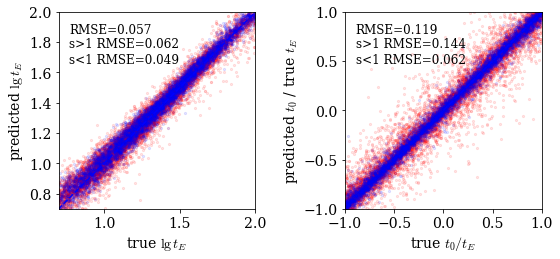

In [7]:
ind_larges = Y_orig[:num, 5] > 1

num=4096 * 4

fig = plt.figure(figsize=(8, 4))

ax2 = plt.subplot(1, 2, 1)
plt.axis('square')
plt.xlim(np.log10(5), 2)
plt.ylim(np.log10(5), 2)
plt.xlabel(r'true $\lg t_E$', fontsize=14)
plt.ylabel(r'predicted $\lg t_E$', fontsize=14)
# plt.scatter(np.log10(Y[:num, 1]), np.log10(pred_rand.numpy()[:num, 1]), s=5, alpha=0.1)
plt.scatter(np.log10(Y[:num, 1][ind_larges]), np.log10(pred.numpy()[:num, 1][ind_larges]), s=5, alpha=0.1, label='s>1', color='red', rasterized=True)
plt.scatter(np.log10(Y[:num, 1][~ind_larges]), np.log10(pred.numpy()[:num, 1][~ind_larges]), s=5, alpha=0.1, label='s<1', color='blue', rasterized=True)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), color='b', linestyle='dashed')
at = AnchoredText(
        "RMSE=%.3f\ns>1 RMSE=%.3f\ns<1 RMSE=%.3f" % (
            np.sqrt(torch.mean((np.log10(Y[:num, 1]) -  np.log10(pred.numpy()[:num, 1]))**2).detach().cpu().item()),
            np.sqrt(torch.mean((np.log10(Y[:num, 1])[ind_larges] -  np.log10(pred.numpy()[:num, 1])[ind_larges])**2).detach().cpu().item()),
            np.sqrt(torch.mean((np.log10(Y[:num, 1])[~ind_larges] -  np.log10(pred.numpy()[:num, 1])[~ind_larges])**2).detach().cpu().item()),
            ), prop=dict(size=12), frameon=False, loc='upper left')
ax2.add_artist(at)
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('rmse of lgt_E: ', torch.sqrt((torch.mean((np.log10(Y[:num, 1]) -  np.log10(pred.numpy()[:num, 1]))**2, dim=0))).detach().cpu().item())

ax3 = plt.subplot(1, 2, 2)
plt.axis('square')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'true $t_0/t_E$', fontsize=14)
plt.ylabel(r'predicted $t_0$ / true $t_E$', fontsize=14)
plt.scatter((Y[:num, 0] / Y[:num, 1])[ind_larges], (pred.numpy()[:num, 0] / Y[:num, 1])[ind_larges], s=5, alpha=0.1, label='s>1', color='red', rasterized=True)
plt.scatter((Y[:num, 0] / Y[:num, 1])[~ind_larges], (pred.numpy()[:num, 0] / Y[:num, 1])[~ind_larges], s=5, alpha=0.1, label='s<1', color='blue', rasterized=True)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), color='b', linestyle='dashed')
at = AnchoredText(
        "RMSE=%.3f\ns>1 RMSE=%.3f\ns<1 RMSE=%.3f" % (
            np.sqrt(torch.mean((Y[:num, 0] / Y[:num, 1] -  (pred.numpy()[:num, 0] / Y[:num, 1]))**2).detach().cpu().item()),
            np.sqrt(torch.mean(((Y[:num, 0] / Y[:num, 1])[ind_larges] -  (pred.numpy()[:num, 0] / Y[:num, 1])[ind_larges])**2).detach().cpu().item()),
            np.sqrt(torch.mean(((Y[:num, 0] / Y[:num, 1])[~ind_larges] -  (pred.numpy()[:num, 0] / Y[:num, 1])[~ind_larges])**2).detach().cpu().item()),
            ), prop=dict(size=12), frameon=False, loc='upper left')
ax3.add_artist(at)

plt.tight_layout()
plt.savefig('./t0te_small.pdf')
plt.show()

In [8]:
((Y[:num] - pred.numpy())**2).mean(-1).sort()[1][-10:]

tensor([ 8935,  3502, 12467,  2762, 15759,  8063, 13678, 14395,  2182,  5951])

tensor([-72.3465,  98.0457], dtype=torch.float64)
tensor([-7.2346e+01,  9.8046e+01,  5.6072e-01,  1.0000e-03,  9.9302e-01,
         2.8113e+00,  1.6047e+02,  1.0041e-01], dtype=torch.float64)
tensor([[41.4227, 53.4789]])
tensor(1.2235, dtype=torch.float64) tensor(0.9930, dtype=torch.float64)


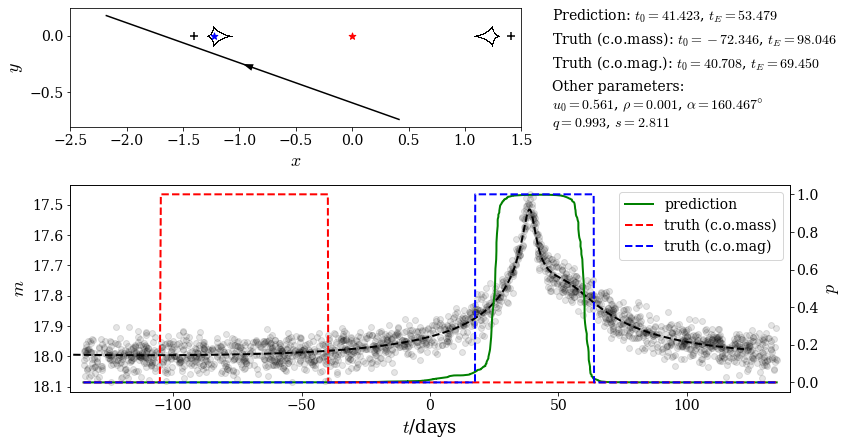

In [28]:
i = 5951
fig = plt.figure(1, (12, 6.4))

ax1 = plt.subplot2grid((5, 3), (2, 0), rowspan=3, colspan=3)
plt.scatter(X[i, :, 0], X[i, :, 1]+6, color='black', marker='o', alpha=0.1, rasterized=True)
plt.ylabel(r'$m$', fontsize=18)
plt.xlabel(r'$t$/days', fontsize=18)
plt.xlim(-140, 140)
param_true = Y_orig[i].tolist()
lc_true = simulate_lc(*param_true, orig=True, orig_param=True)
plt.plot(lc_true[:, 0], lc_true[:, 1] + 14.5 + 2.5 * np.log10(param_true[-1])+6, color='black', linewidth=2, linestyle='dashed')
plt.gca().invert_yaxis()

delta = Y_orig[i, 4] / (1 + Y_orig[i, 4]) * (Y_orig[i, 5] - 1 / (Y_orig[i, 5]))
t0_new = Y_orig[i, 0] - Y_orig[i, 1] * np.cos(np.pi/180*Y_orig[i, -2]) * delta
tE_new = Y_orig[i, 1] / np.sqrt(1 + Y_orig[i, 4])

# at = AnchoredText(
#         "$t_0=%.3f$\n$t_0'=%.3f$\n$t_E=%.3f$\n$s=%.3f$" % (
#             Y_orig[i, 0], t0_new, Y_orig[i, 1], Y_orig[i, 5]
#             ), prop=dict(size=16), frameon=False, loc='upper right')
# plt.gca().add_artist(at)

model.plot = False
model.animate = True
res = model(train_coeffs[[i]].float().to(device), Y[[i]].float().to(device))
pred_ = res[0].detach().cpu()
z_ = res[2].detach().cpu()
ax = plt.gca().twinx()
plt.plot(z_[0, :, 0], z_[0, :, 1], color='green', linewidth=2, label='prediction')
left = Y[i, 0] - Y[i, 1] * k
right = Y[i, 0] + Y[i, 1] * k
zt = ((z_[0, :, 0] > left) * (z_[0, :, 0] < right)).int().float()
plt.plot(z_[0, :, 0], zt, color='red', linewidth=2, linestyle='dashed', label = 'truth (c.o.mass)')
left = t0_new - tE_new * k
right = t0_new + tE_new * k
zt = ((z_[0, :, 0] > left) * (z_[0, :, 0] < right)).int().float()
plt.plot(z_[0, :, 0], zt, color='blue', linewidth=2, linestyle='dashed', label = 'truth (c.o.mag)')
plt.ylabel(r'$p$', fontsize=18)
plt.legend(loc='upper right')


print(Y[i])
print(Y_orig[i])
print(pred_)


t_0, t_E, u_0, rho, q, s, alpha, fs = Y_orig[i].tolist()
parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': rho, 
            'q': q, 
            's': s, 
            'alpha': alpha,
        }
ax2 = plt.subplot2grid((5, 3), (0, 0), rowspan=2, colspan=2)
plt.axis('equal')
plt.xlim(-2.5, 1.5)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)
modelmm = mm.Model(parameters, coords=None)
modelmm.plot_trajectory(t_range=(-135, 135), caustics=False, arrow=True, color='black')
modelmm.plot_caustics(color='black', s=1)

# com
plt.scatter(0, 0, s=50, color='red', marker='*')
plt.scatter(-delta, 0, s=50, color='blue', marker='*')
plt.scatter(-Y_orig[i, 4] / (1 + Y_orig[i, 4]) * Y_orig[i, 5], 0, s=50, color='black', marker='+')
plt.scatter(1 / (1 + Y_orig[i, 4]) * Y_orig[i, 5], 0, s=50, color='black', marker='+')
print(delta, Y_orig[i, 4])

ax3 = plt.subplot2grid((5, 3), (0, 2), rowspan=2, colspan=1)
ax3.axis('off')

plt.text(-0.3, 0.9, r'Prediction: $t_0=%.3f$, $t_E=%.3f$' % (pred_[0, 0], pred_[0, 1]), fontsize=14)
plt.text(-0.3, 0.7, r'Truth (c.o.mass): $t_0=%.3f$, $t_E=%.3f$' % (t_0, t_E), fontsize=14)
plt.text(-0.3, 0.5, r'Truth (c.o.mag.): $t_0=%.3f$, $t_E=%.3f$' % (t0_new, tE_new), fontsize=14)
plt.text(-0.3, 0.15, r'Other parameters:' '\n' r'$u_0=%.3f$, $\rho=%.3f$, $\alpha=%.3f\degree$' % (
    u_0, rho, alpha
), fontsize=14)
plt.text(-0.3, 0, r'$q=%.3f$, $s=%.3f$' % (
    q, s
), fontsize=14)

plt.tight_layout()
plt.savefig('./lc_s_wide.pdf')
plt.show()

In [11]:
lc_smalls = X[:num][~ind_larges]
y_smalls = Y[:num][~ind_larges]
z_smalls = z[:num][~ind_larges]
y_orig_smalls = Y_orig[:num][~ind_larges]
lc_smalls[:, :, 0] = (lc_smalls[:, :, 0] - y_smalls[:, [0]]) / y_smalls[:, [1]]
z_smalls[:, :, 0] = (z_smalls[:, :, 0] - y_smalls[:, [0]]) / y_smalls[:, [1]]

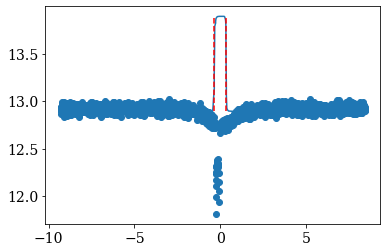

In [12]:
i = 0
plt.scatter(lc_smalls[i, :, 0], lc_smalls[i, :, 1])
plt.plot(z_smalls[i, :, 0], z_smalls[i, :, 1] + lc_smalls[i, :, 1].mean())
plt.vlines([-k, k], lc_smalls[i, :, 1].mean(), lc_smalls[i, :, 1].mean() + 1, linestyles='dashed', color='red')

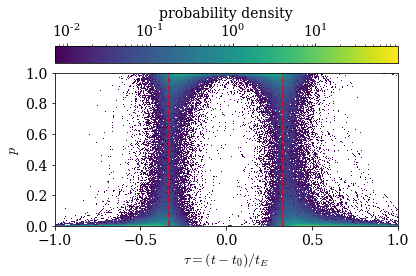

In [20]:
fig = plt.figure(figsize=(6, 4))
plt.hist2d(z_smalls[:, :, 0].numpy().flatten(), z_smalls[:, :, 1].numpy().flatten(), bins=[10000, 1000], density=True, norm=mpl.colors.LogNorm(), rasterized=True)
plt.xlim(-1, 1)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel(r'$\tau=(t-t_0)/t_E$')
plt.ylabel(r'$p$')
plt.ylim(0, 1)
plt.colorbar(label='probability density', location='top')
plt.vlines([-k, k], 0, 1, linestyles='dashed', color='red')
plt.tight_layout()
plt.savefig('./p_dist.pdf')
plt.show()

In [33]:
k_list = [1/3, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
name_list = ['54125', 'k=0.75', 'k=1', 'k=1.25', 'k=1.5', 'k=1.75', 'smallte']
method = 'avg'
num = 4096*4
batchsize = 128

rmse_lgte = []
rmse_t0overte = []
rmse_t0 = []

ind_larges = Y_orig[:num, 5] > 1

for k, name in tqdm(zip(k_list, name_list)):
    checkpt = torch.load(f'/work/hmzhao/experiments/locator/experiment_{name}.ckpt', map_location='cpu')
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

    ckpt_args = checkpt['args']
    state_dict = checkpt['state_dict']

    model = Locator(device, k=k, method=method).to(device)
    model_dict = model.state_dict()

    # 1. filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(state_dict) 
    # 3. load the new state dict
    model.load_state_dict(state_dict)
    model.to(device)

    pred = torch.zeros((num, 2))
    y_ref = torch.zeros((batchsize, 2)).to(device)
    z = torch.zeros((num, 4000, 2))
    model.eval()
    model.plot = False
    model.soft_threshold = True
    model.threshold = 0.5
    model.animate = False
    with torch.no_grad():
        for i in tqdm(range(num // batchsize)):
            batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
            y_ref = Y[i*batchsize:i*batchsize+batchsize].float().to(device)
            res = model(batch, y_ref)
            pred[i*batchsize:i*batchsize+batchsize] = res[0].detach().cpu()
    rmse_lgte.append(np.sqrt(torch.mean((np.log10(Y[:num, 1])[~ind_larges] -  np.log10(pred.numpy()[:num, 1])[~ind_larges])**2).detach().cpu().item()))
    rmse_t0overte.append(np.sqrt(torch.mean(((Y[:num, 0] / Y[:num, 1])[~ind_larges] -  (pred.numpy()[:num, 0] / Y[:num, 1])[~ind_larges])**2).detach().cpu().item()))
    rmse_t0.append(np.sqrt(torch.mean((Y[:num, 0] -  pred.numpy()[:num, 0])**2).detach().cpu().item()))

0it [00:00, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

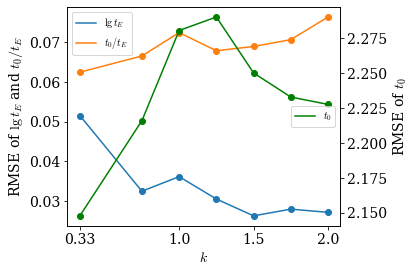

In [40]:
plt.plot(k_list, rmse_lgte, label=r'$\lg t_E$')
plt.scatter(k_list, rmse_lgte)
plt.plot(k_list, rmse_t0overte, label=r'$t_0/t_E$')
plt.scatter(k_list, rmse_t0overte)
plt.xticks([1/3, 1, 1.5, 2], [0.33, 1.00, 1.50, 2.00])
plt.xlabel(r'$k$', fontsize=14)
plt.ylabel(r'RMSE of $\lg t_E$ and $t_0/t_E$', fontsize=14)
plt.legend(prop={'size': 10})

ax = plt.gca().twinx()
plt.plot(k_list, rmse_t0, label=r'$t_0$', color='green')
plt.scatter(k_list, rmse_t0, color='green')
plt.ylabel(r'RMSE of $t_0$', fontsize=14)

plt.legend(prop={'size': 10}, loc='right')
plt.tight_layout()
plt.savefig('./rmse_k.pdf')
plt.show()